# Image Contrast Examples

This page shows examples of different MRI contrasts, as well as examples of how to simulate MRI contrast.

## Learning Goals

1. Describe how various types of MRI contrast are created
    * Identify various image contrasts

## Image Contrast Examples

![Brain contrast from Pauly and Gold](images/contrast_brain_example.png)

![Brain contrast from Vasily Yarnkh](images/contrast_brain_example-all.png)

![Knee contrast](images/contrast_knee_example.png)


## Simple Contrast Phantom

Below is a simple contrast phantom consisting of three circular objects, each with a different $T_1$ and $T_2$.  The k-space data for these phantoms is created using a "jinc" function, which is the Fourier Transform of a circle:

$$\mathcal{F}\{ \mathrm{circ}(r) \} = \mathrm{jinc}(k_r)$$

The signal is simulated for varying sequence parameters (TE, TR) with a 90-degree flip angle in a gradient-echo scheme by using the helper function:

```Octave
signal_gre = MRsignal_spoiled_gradient_echo(flip, TE, TR, M0, T1, T2)
```

### Challenge Yourself!

Based on the images and TE/TR parameters below, can you estimate T1 and T2 relaxation times of the 3 objects?

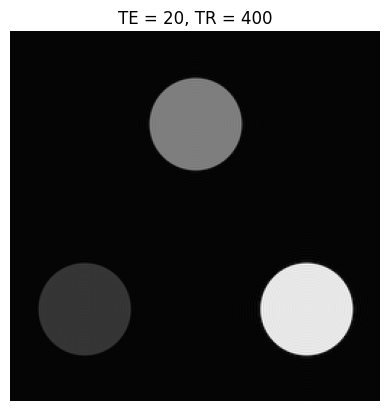

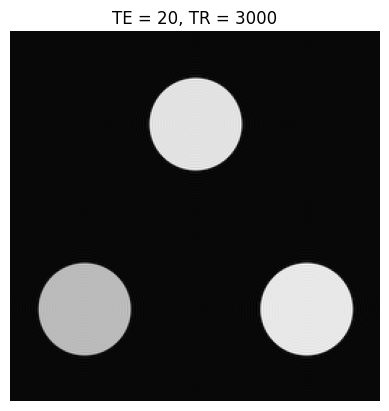

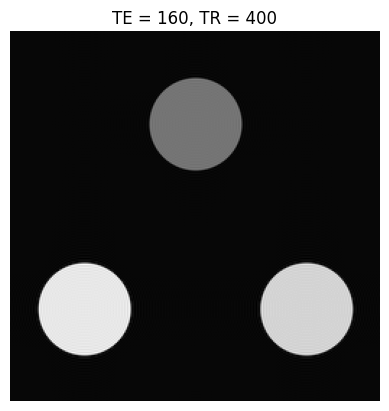

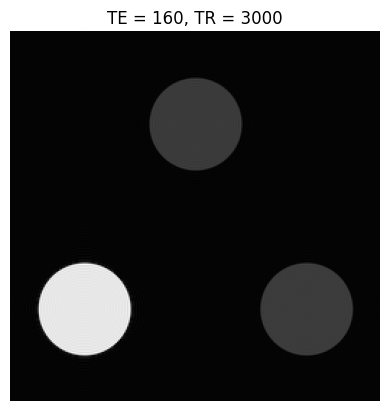

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# Helper functions (you must define these elsewhere in your notebook or import them)

def jinc(x):
    # Avoid division by zero
    result = np.ones_like(x)
    mask = x != 0
    result[mask] = j1(np.pi * x[mask]) / (2 * x[mask])
    return result

def MRsignal_spoiled_gradient_echo(flip, TE, TR, M0, T1, T2):
    # Calculate the MR signal for a spoiled gradient echo sequence
    E1 = np.exp(-TR / T1)
    E2 = np.exp(-TE / T2)
    return M0 * (1 - E1) * np.sin(flip) * E2 / (1 - E1 * np.cos(flip))

Nphan = 3
# phantom parameters
xc = np.array([-.3, 0, .3]) * 256  # x centers
yc = np.array([-.25, .25, -.25]) * 256  # y centers
M0 = np.array([1, 1, 1])  # relative proton densities
T1 = np.array([.3, .8, 3]) * 1e3  # T1 relaxation times (ms)
T2 = np.array([.06, .06, .2]) * 1e3  # T2 relaxation times (ms)
r = 1/64  # ball radius, where FOV = 1

flip = 90 * np.pi / 180
TEs = [20, 160]
TRs = [400, 3000]

N = 256

# matrices with kx, ky coordinates
kx, ky = np.meshgrid(np.arange(-N/2, N/2) / N, np.arange(-N/2, N/2) / N)

for TE in TEs:
    for TR in TRs:
        # initialize k-space data matrix
        M = np.zeros((N, N), dtype=complex)

        # Generate k-space data by adding together k-space data for each individual phantom
        for n in range(Nphan):
            # Generates data using Fourier Transform of a circle (jinc) multiplied by complex exponential to shift center location
            M = M + jinc(np.sqrt(kx**2 + ky**2) / r) * \
                np.exp(1j * 2 * np.pi * (kx * xc[n] + ky * yc[n])) * \
                MRsignal_spoiled_gradient_echo(flip, TE, TR, M0[n], T1[n], T2[n])

        # reconstruct and display ideal image
        m = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(M)))
        plt.figure()
        plt.imshow(np.abs(m), cmap='gray', aspect='equal')
        plt.axis('off')
        plt.title(f'TE = {TE}, TR = {TR}')
        plt.show()